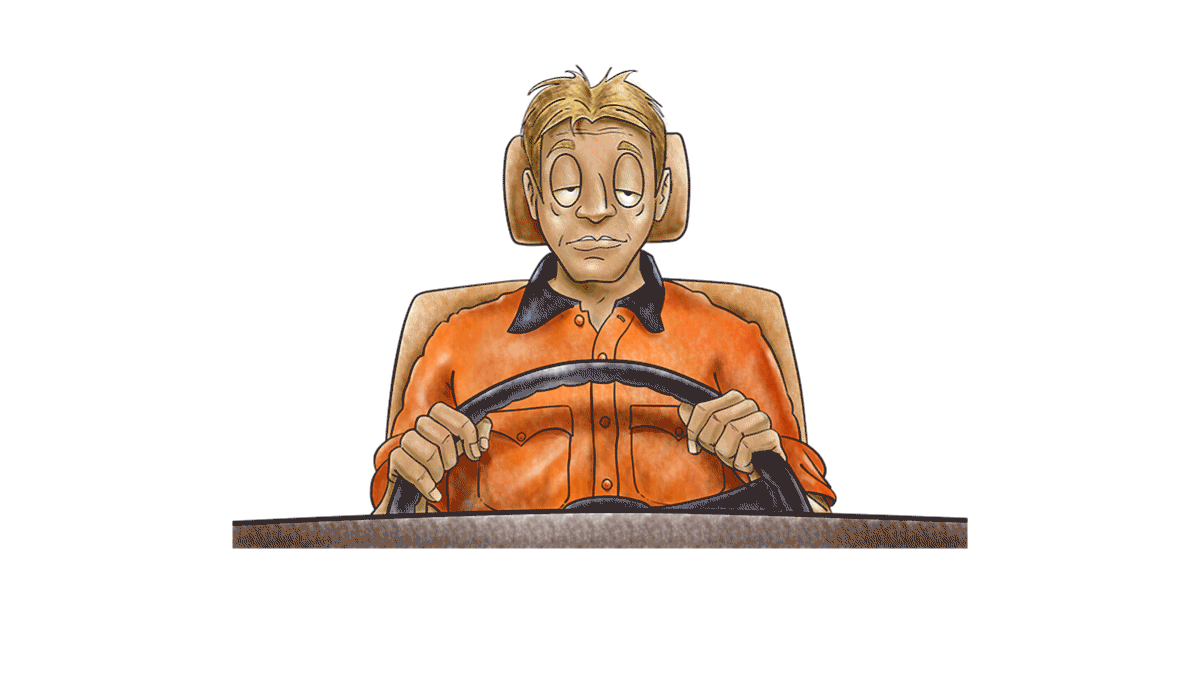

## Driver drowsiness detection is a car safety technology which helps prevent accidents caused by the driver getting drowsy. Various studies have suggested that around 20% of all road accidents are fatigue-related, up to 50% on certain roads.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

# labels

In [2]:
labels = os.listdir(".")

In [3]:
labels

['.ipynb_checkpoints',
 'archive.zip',
 'driver-drowsiness-using-keras - Copy.ipynb',
 'driver-drowsiness-using-keras.ipynb',
 'haarcascade_eye.xml',
 'haarcascade_frontalface_default.xml',
 'train']

# visualize random 1 image

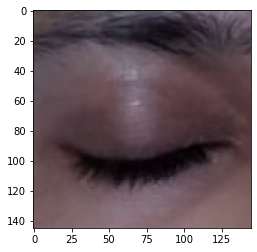

In [5]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("./train/Closed/_0.jpg"))

# image array

In [51]:
a = plt.imread("./train/yawn/10.jpg")

# image shape

In [7]:
a.shape

(480, 640, 3)

# visualize yawn image. 
# Here background is unnecessary. we need only face image array

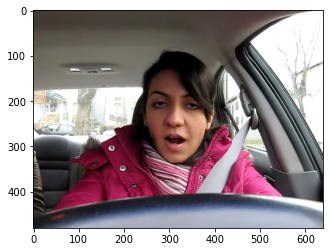

In [8]:
plt.imshow(plt.imread("./train/yawn/10.jpg"))

# for yawn and not_yawn. Take only face

In [9]:
def face_for_yawn(direc="./train",
face_cas_path="haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), 
                                     cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, 
                                    (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye

In [10]:
def get_data(dir_path="./train",
    face_cas="haarcascade_frontalface_default.xml",
    eye_cas="haarcascade_eyes.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [11]:
data_train = get_data()

2
3


# extend data and convert array

In [12]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

# new variable to store

In [13]:
new_data = append_data()

0
1
2
3


<ipython-input-12-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(yaw_no)


# separate label and features

In [14]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [15]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [16]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [17]:
y = np.array(y)

# train test split

In [18]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [19]:
len(X_test)

578

# Not necessary, only use to matching with my pc version

In [20]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [22]:
tf.__version__

'2.7.0'

# keras version

In [23]:
import keras
keras.__version__

'2.7.0'

# Data Augmentation

In [24]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [25]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [26]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 277s 6s/step - loss: 1.1453 - accuracy: 0.4840 - val_loss: 0.7220 - val_accuracy: 0.7370
Epoch 2/50
43/43 [==============================] - 270s 6s/step - loss: 0.5365 - accuracy: 0.7765 - val_loss: 0.5658 - val_accuracy: 0.7422
Epoch 3/50
43/43 [==============================] - 273s 6s/step - loss: 0.4064 - accuracy: 0.8233 - val_loss: 0.3543 - val_accuracy: 0.8668
Epoch 4/50
43/43 [==============================] - 323s 8s/step - loss: 0.3354 - accuracy: 0.8500 - val_loss: 0.2968 - val_accuracy: 0.8858
Epoch 5/50
43/43 [==============================] - 276s 6s/step - loss: 0.2749 - accuracy: 0.8820 - val_loss: 0.2450 - val_accuracy: 0.8910
Epoch 6/50
43/43 [==============================] - 271s 6s/step - loss: 0.2675 - accuracy: 0.8864 - val_loss: 0.3040 - val_accuracy: 0.8858
Epoch 7/50
43/43 [==============================] - 270s 6s/step - loss: 0.2764 - accuracy: 0.8753 - val_loss: 0.1936 - val_accuracy: 0.9152
Epoch 8/50
43

# history

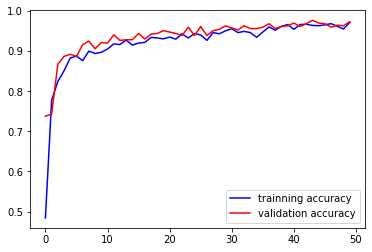

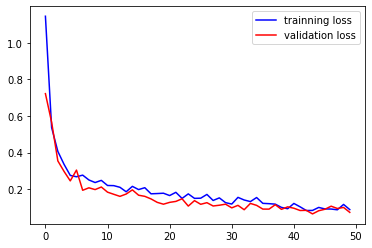

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [28]:
model.save("drowiness_new6.h5")

In [29]:
model.save("drowiness_new6.model")

INFO:tensorflow:Assets written to: drowiness_new6.model\assets


# Prediction

In [30]:
prediction = model.predict(X_test)

In [31]:
pd.DataFrame(y_test)

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,1,0,0
...,...,...,...,...
573,0,0,1,0
574,0,0,1,0
575,0,0,0,1
576,0,0,1,0


In [32]:
import pandas as pd
pd.DataFrame(y_test).cumsum()

,0,1,2,3
0,0,0,0,1
1,0,0,0,2
2,0,0,1,2
3,0,0,1,3
4,0,1,1,3
...,...,...,...,...
573,63,74,212,225
574,63,74,213,225
575,63,74,213,226
576,63,74,214,226


In [33]:
prediction.shape

(578, 4)

# classification report

In [34]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [35]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1), target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.88      0.84      0.86        63
     no_yawn       0.79      0.92      0.85        74
      Closed       1.00      0.48      0.65       215
        Open       0.68      0.99      0.80       226

    accuracy                           0.77       578
   macro avg       0.84      0.81      0.79       578
weighted avg       0.83      0.77      0.76       578



# predicting function

In [43]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [44]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("./train/no_yawn/7.jpg")])
np.argmax(prediction)

3

In [45]:
prediction = model.predict([prepare("./train/Closed/_101.jpg")])
np.argmax(prediction)

2

In [46]:
prediction = model.predict([prepare("./train/Open/_104.jpg")])
np.argmax(prediction)

3

In [50]:
prediction = model.predict([prepare("./train/yawn/116.jpg")])
np.argmax(prediction)

1